<a href="https://colab.research.google.com/github/jslee0110/.2023-1aidl/blob/main/earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

내 드라이브>earthquake 파일을 만들어서 거기에 모든 자료를 넣은 조건의 코드입니다!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score
from xgboost import XGBClassifier


# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin

from pathlib import Path
import pickle
from os import PathLike
import torch

In [3]:



TRAINING_FEATURES_PATH = '/content/drive/MyDrive/earthquake/train_values.csv'
TRAINING_LABELS_PATH = '/content/drive/MyDrive/earthquake/train_labels.csv'
TEST_FEATURES_PATH = '/content/drive/MyDrive/earthquake/test_values.csv'
SUBMISSION_FORMAT_PATH = '/content/drive/MyDrive/earthquake/submission_format.csv'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

데이터 불러오기

In [4]:
features_df         = pd.read_csv(TRAINING_FEATURES_PATH,   index_col=0)
labels_df           = pd.read_csv(TRAINING_LABELS_PATH,     index_col=0) - 1
test_features_df    = pd.read_csv(TEST_FEATURES_PATH,       index_col=0)

데이터 전처리

In [5]:
# Setup

geo_level_columns = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']
numerical_columns = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']
categorical_columns = ['foundation_type', 'ground_floor_type', 'land_surface_condition', 
                       'legal_ownership_status', 'other_floor_type',
                       'plan_configuration', 'position', 'roof_type']

In [6]:
class ThresholdReplacer(BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin):
    
    def __init__(self, threshold: int, unk_value: int = -1) -> None:
        super().__init__()
        self.threshold = threshold
        self.unk_value = unk_value

    def fit(self, X, y=None):
        assert isinstance(X, pd.DataFrame)

        self.columnwise_keep_categories = {
            column: self._get_keep_categories(X[column]) for column in X.columns
        }

        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        out = X.copy()

        for column, keep_categories in self.columnwise_keep_categories.items():
          unique_values = out[column].unique()
          to_replace = set(unique_values).difference(set(keep_categories))
          out[column].replace(to_replace, self.unk_value, inplace=True)

        return out

    def _get_keep_categories(self, series: pd.Series) -> pd.Series:
        return ( 
            series
              .value_counts()
              .index[(series.value_counts() > self.threshold)]
        ) # type: ignore

In [7]:
class DREncoder(torch.nn.Module):

    def __init__(self, 
                 latent_dim: int=16, 
                 geo_lv1_size: int=31, 
                 geo_lv2_size: int=1414,
                 geo_lv3_size: int=11861) -> None:
        super().__init__()
        self.geo_level1_embeddings = torch.nn.Embedding(geo_lv1_size, 16)
        self.geo_level2_embeddings = torch.nn.Embedding(geo_lv2_size, 128)
        self.geo_level3_embeddings = torch.nn.Embedding(geo_lv3_size, 128) 
        self.compressor = torch.nn.Linear(16+128+128, latent_dim)

    def forward(self, x):
        x_1 = self.geo_level1_embeddings(x[:, 0])
        x_2 = self.geo_level2_embeddings(x[:, 1])
        x_3 = self.geo_level3_embeddings(x[:, 2])
        x = torch.concat((x_1, x_2, x_3), dim=1)
        x = torch.nn.functional.relu(x)
        return torch.nn.functional.relu(self.compressor(x))


class GeoDimensionReduction0(BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin):

    def __init__(
            self, 
            path: PathLike,
            latent_dim: int=16, 
            geo_lv1_size: int=31,
            geo_lv2_size: int=1418,
            geo_lv3_size: int=11861) -> None:
        super().__init__()
        self.path = path
        self.model = DREncoder(
            latent_dim, 
            geo_lv1_size,
            geo_lv2_size,
            geo_lv3_size
        )
        self.latent_dim = latent_dim
        self.geo_lv1_size = geo_lv1_size
        self.geo_lv2_size = geo_lv2_size
        self.geo_lv3_size = geo_lv3_size
        self.model.load_state_dict(torch.load(path, map_location=DEVICE))

    def fit(self, X: pd.DataFrame, y=None, *args, **kwargs):
        return self

    def transform(self, X: pd.DataFrame, y=None, *args, **kwargs):
        # Convert pd to numpy
        if isinstance(X, pd.DataFrame):
            X = X.values # type: ignore
        # Apply encoder
        self.model.eval()
        X = torch.from_numpy(X).type(torch.long) # type: ignore
        return self.model(X).detach().numpy()
    

In [8]:
# Load All Label Encoders
with open('/content/drive/MyDrive/earthquake/geo-lv-1-label-encoder.pickle', 'rb') as f:
    le1 = pickle.load(f)
with open('/content/drive/MyDrive/earthquake/geo-lv-2-label-encoder.pickle', 'rb') as f:
    le2 = pickle.load(f)
with open('/content/drive/MyDrive/earthquake/geo-lv-3-label-encoder.pickle', 'rb') as f:
    le3 = pickle.load(f)

# Prepare Transformers
geo_lv1_le = FunctionTransformer(
    func=lambda x: np.array(le1.transform(x.values.ravel())).reshape(-1, 1),
    feature_names_out='one-to-one'
)

geo_lv2_le = FunctionTransformer(
    func=lambda x: np.array(le2.transform(x.values.ravel())).reshape(-1, 1), 
    feature_names_out='one-to-one'
)

geo_lv3_le = FunctionTransformer(
    func=lambda x: np.array(le3.transform(x.values.ravel())).reshape(-1, 1), 
    feature_names_out='one-to-one'
)

# Dim Reducer
geo_dim_reduction_preprocessor = ColumnTransformer(
    transformers=[
        ('geo1_le', geo_lv1_le, ['geo_level_1_id']),
        ('geo2_le', geo_lv2_le, ['geo_level_2_id']),
        ('geo3_le', geo_lv3_le, ['geo_level_3_id']),
    ], 
    remainder='drop', 
    verbose_feature_names_out=False
).set_output(transform='pandas')

geo_dim_reduction_pipe = Pipeline([
    ('label_encoder', geo_dim_reduction_preprocessor),
    ('embedder', GeoDimensionReduction0('/content/drive/MyDrive/earthquake/project-dr-16.pt', latent_dim=16)),
])


preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(drop='first', handle_unknown='ignore', min_frequency=1, sparse=False), categorical_columns + ['geo_level_1_id']),
        ('geo_dim_reduction', geo_dim_reduction_pipe, geo_level_columns),
        ('geo_unk',  ThresholdReplacer(3, -1), geo_level_columns),
    ],
    remainder='passthrough'
)
preprocessor.set_output(transform='pandas')

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 1.2.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore',
                                               min_frequency=1, sparse=False),
                                 ['foundation_type', 'ground_floor_type',
                                  'land_surface_condition',
                                  'legal_ownership_status', 'other_floor_type',
                                  'plan_configuration', 'position', 'roof_type',
                                  'geo_level_1_id']),
                                ('geo_dim_reduction',
                                 Pipeli...
                                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                                       func=<function <lambda> at 0x7f3fd23e8a60>),
                                                                                   ['geo_level_3_id'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('embedder',
                                                  GeoDimensionReduction0(path='/content/drive/MyDrive/earthquake/project-dr-16.pt'))]),
                                 ['geo_level_1_id', 'geo_level_2_id',
                                  'geo_level_3_id']),
                                ('geo_unk', ThresholdReplacer(threshold=3),
                                 ['geo_level_1_id', 'geo_level_2_id',
                                  'geo_level_3_id'])])

In [9]:
X_train = preprocessor.fit_transform(features_df, labels_df)
y_train = labels_df.to_numpy().squeeze()
X_test = preprocessor.transform(test_features_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


submission

In [11]:
from os import PathLike
import pandas as pd


def create_submission(predictions, submission_formats_path: PathLike):
    submission_format = pd.read_csv(submission_formats_path, index_col=0)
    submission = pd.DataFrame(data=predictions, columns=submission_format.columns, index=submission_format.index)
    submission['damage_grade'] = submission['damage_grade'].astype(int)
    return submission
hyperparams = {
    'booster': 'gbtree', 'colsample_bytree': 0.7000000000000001, 
    'eta': 0.025, 'eval_metric': 'auc', 'gamma': 0.9, 'max_depth': 11, 
    'min_child_weight': 6.0, 'n_estimators': 969, 'nthread': 6, 
    'seed': 42, 'subsample': 0.8, 'tree_method': 'gpu_hist'
}

xgb = XGBClassifier(**hyperparams, objective='multi:softmax')

xgb.fit(
    X=X_train, 
    y=y_train,  
    verbose=0
)

submission = create_submission(xgb.predict(X_test) + 1, submission_formats_path=SUBMISSION_FORMAT_PATH)


In [13]:
submission.to_csv('/content/drive/MyDrive/earthquake/pp11-1-xgb.csv')

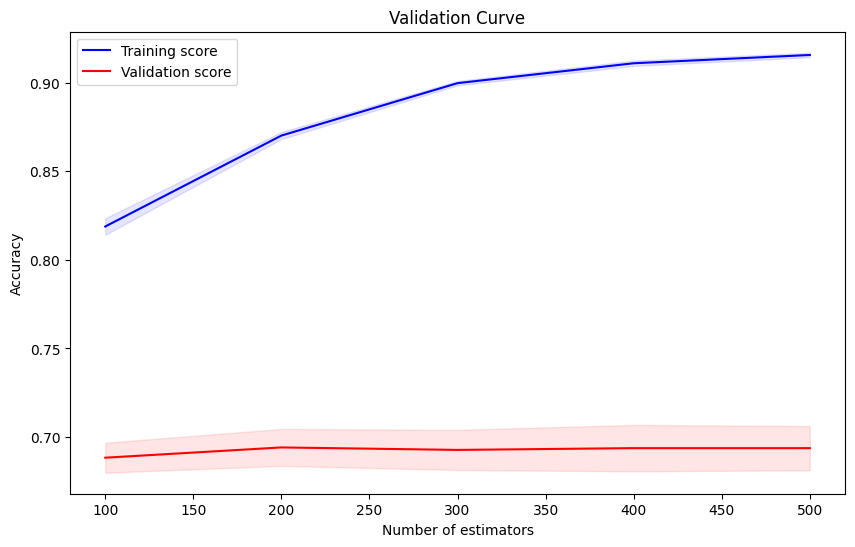

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.utils import shuffle

# Reduce the size of the dataset or perform sampling
sample_size = 10000  # Specify the desired sample size
X_train_sampled, y_train_sampled = shuffle(X_train, y_train, random_state=42)
X_train_sampled = X_train_sampled[:sample_size]
y_train_sampled = y_train_sampled[:sample_size]

# Define the parameter range to evaluate
param_range = [100, 200, 300, 400, 500]

# Calculate validation scores for each parameter value
train_scores, valid_scores = validation_curve(
    estimator=xgb,
    X=X_train_sampled,
    y=y_train_sampled,
    param_name='n_estimators',
    param_range=param_range,
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',
    n_jobs=-1  # Use all available CPU cores for parallel execution
)

# Calculate the mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training score', color='blue')
plt.plot(param_range, valid_mean, label='Validation score', color='red')

# Fill the area between the mean training scores and the mean +/- standard deviation of the validation scores
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='red')

# Add labels and title
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('Validation Curve')
plt.legend(loc='best')

# Show the plot
plt.show()



전체 데이터에 대한 validity그래프(너무 오래 걸림. 돌아갈지 의문)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve

# Define the parameter range to evaluate
param_range = [100, 200, 300, 400, 500]

# Calculate validation scores for each parameter value
train_scores, valid_scores = validation_curve(
    estimator=xgb,
    X=X_train,
    y=y_train,
    param_name='n_estimators',
    param_range=param_range,
    cv=5,  # Number of cross-validation folds
    scoring='accuracy',
    n_jobs=-1  # Use all available CPU cores for parallel execution
)

# Calculate the mean and standard deviation of training and validation scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, label='Training score', color='blue')
plt.plot(param_range, valid_mean, label='Validation score', color='red')

# Fill the area between the mean training scores and the mean +/- standard deviation of the validation scores
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.fill_between(param_range, valid_mean - valid_std, valid_mean + valid_std, alpha=0.1, color='red')

# Add labels and title
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.title('Validation Curve')
plt.legend(loc='best')

# Show the plot
plt.show()


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: ignored